## Genre Recommendation 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data.csv',encoding='latin1')

In [3]:
df = df.drop(['beats'], axis=1)

In [4]:
df.head()

,class_name,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues,103.359375,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues,95.703125,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues,151.999081,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues,184.570312,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues,161.499023,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [5]:
df['class_name'].unique()

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [6]:
df['class_name'] = df['class_name'].astype('category')
df['class_label'] = df['class_name'].cat.codes

In [7]:
lookup_genre_name = dict(zip(df.class_label.unique(), df.class_name.unique()))   
lookup_genre_name

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [8]:
df['class_name'].unique()

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Categories (10, object): ['blues', 'classical', 'country', 'disco', ..., 'metal', 'pop', 'reggae', 'rock']

In [1]:
cols = list(df.columns)
cols.remove('label')
cols.remove('class_label')
cols.remove('class_name')
#df[cols]

NameError: name 'df' is not defined

In [10]:
%matplotlib notebook
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X = df.iloc[:,1:28]
y = df['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test) 

<IPython.core.display.Javascript object>


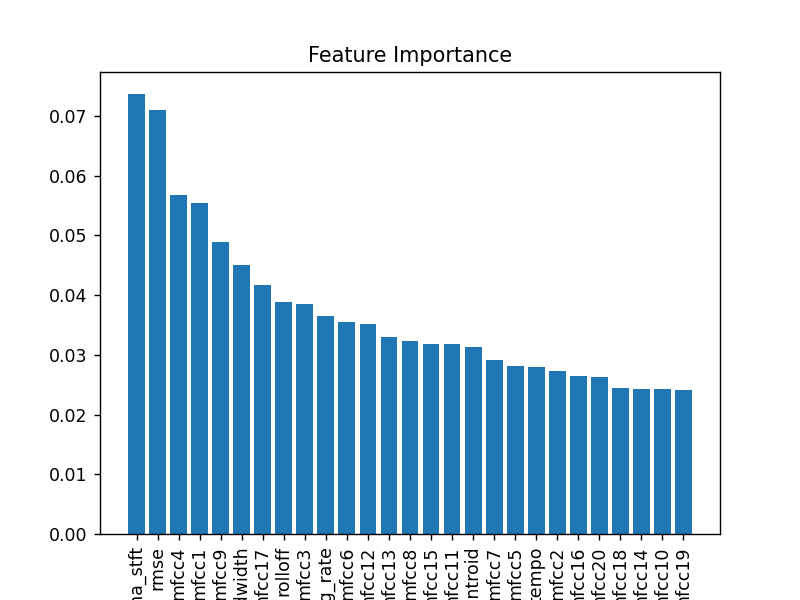

In [12]:
from sklearn.ensemble import RandomForestClassifier
%matplotlib notebook
clf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns.values[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.show()

## SVM with all 27 features 

In [13]:
!pip install librosa


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
def getmetadata(filename):
    import librosa
    import numpy as np


    y, sr = librosa.load(filename)
    #fetching tempo

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

    #fetching beats

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_percussive,sr=sr)

    #chroma_stft

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

    #rmse

    rmse = librosa.feature.rms(y=y)

    #fetching spectral centroid

    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    #spectral bandwidth

    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    #fetching spectral rolloff

    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]

    #zero crossing rate

    zero_crossing = librosa.feature.zero_crossing_rate(y)

    #mfcc

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    #metadata dictionary

    metadata_dict = {'tempo':tempo,'chroma_stft':np.mean(chroma_stft),'rmse':np.mean(rmse),
                     'spectral_centroid':np.mean(spec_centroid),'spectral_bandwidth':np.mean(spec_bw), 
                     'rolloff':np.mean(spec_rolloff), 'zero_crossing_rates':np.mean(zero_crossing)}

    for i in range(1,21):
        metadata_dict.update({'mfcc'+str(i):np.mean(mfcc[i-1])})

    return list(metadata_dict.values())

In [15]:
a = getmetadata("sample1.wav")

<ipython-input-14-7fbc258bf7da>:10: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)


In [16]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=10, gamma=0.9, probability=False).fit(X_train_scaled, y_train)
clf.score(X_test_scaled, y_test)

0.76

In [17]:
d1 =np.array(a)
data1 = scaler.transform([d1])
genre_prediction = clf.predict(data1)
genre_name = lookup_genre_name[genre_prediction[0]]

D:\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [18]:
print(genre_name)

disco


## Song Recommendation 

In [19]:
import pandas as pd

def song_recommendation(genre_name):
    # read the CSV file into a DataFrame
    songs_df = pd.read_csv('musicc.csv', encoding='Windows-1252')

    # filter the DataFrame to only include rows with the predicted genre
    filtered_df = songs_df[songs_df['genre'] == genre_name]

    # get a list of 5 random song names with the predicted genre
    song_names = filtered_df['song_name'].sample(n=5).tolist()

    # return the list of song names
    return song_names

In [20]:
# call the function with the predicted genre name
recommended_songs = song_recommendation(genre_name)

# print the recommended songs
print(recommended_songs)

['"Get Lucky" by Daft Punk ft. Pharrell Williams', '"Stayin\' Alive" by Bee Gees', '"Blinding Lights" by The Weeknd', '"Dancing Queen" by ABBA', '"I Feel Love" by Donna Summer']
